# Latent Dirichlet Allocation
## NPFL097 Assignment 1
### Jiří Balhar

In this notebook I use my implementation of LDA topic model to analyse a collection of 18000 news posts from 20newsgroups dataset. This notebook is divided into 6 sections following the assignment structure. For each task I show the task assignment, solution code, required outputs and my comment, if needed.

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
from lda import LDATopicModel, load_data

In [11]:
# load cached data if available
cache_path = "preprocessed_20newsgroups.pickle"
if os.path.isfile(cache_path):
    with open(cache_path, "rb") as f:
        docs, docs_test, dictionary = pickle.load(f)
else:
    docs, docs_test, dictionary = load_data()
    # save docs and dictionary to cache using pickle
    with open(cache_path, "wb") as f:
        pickle.dump((docs, docs_test, dictionary), f)

# also load the original data
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset="train")

## Task 1
Implement the Latent Dirichlet allocation topic model, as described in
the previous lectures. Set the hyperparameters α = 0.1, γ = 0.1 and set
number of topics K = 20.

In [12]:
topics = 20
alpha = 0.1
gamma = 0.1
model = LDATopicModel(docs, dictionary, topics, alpha, gamma)
result_dir = f"ldamodel_topics{topics}_alpha{alpha}_gamma{gamma}"

## Task 2
Plot the distribution over topics for the longest document in the data after
initialization and after 1st, 2nd, 5th, 10th, 20th, 50th, and 100th iteration.
Comment on these. 

In [15]:
# show the longest document
max_len_document = np.array([len(d) for d in docs]).argmax()

print("First 30 tokens of the longest document:")
print(" ".join(dictionary[x] for x in docs[max_len_document][:30]))
print("Original category:", newsgroups_train.target_names[newsgroups_train.target[max_len_document]])
print("Original text (first 500 characters):")
print(newsgroups_train.data[max_len_document][:500])

First 30 tokens of the longest document:
stein washington mitch sport hockey frequent ask question univers washington expir repli washington nntp host stein washington archiv hockey sport hockey answer frequent ask question news content info minor leagu
Original category: rec.sport.hockey
Original text (first 500 characters):
From: hamlet@stein.u.washington.edu (Mitch McGowan)
Subject: rec.sport.hockey Frequently Asked Questions
Organization: University of Washington
Lines: 1768
Expires: Mon, 03 May 93 00:00:01 EDT
Reply-To: hamlet@u.washington.edu
NNTP-Posting-Host: stein.u.washington.edu

Archive-name: hockey-faq

rec.sport.hockey answers to Frequently Asked Questions and other news:
 
Contents:

0. New Info.
1. NHL
2. NHL Minor Leagues
3. College Hockey (North America)
4. Other leagues (e.g. Europe, Canada Cup tou


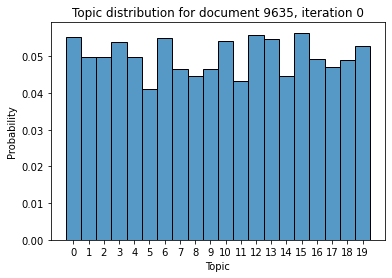

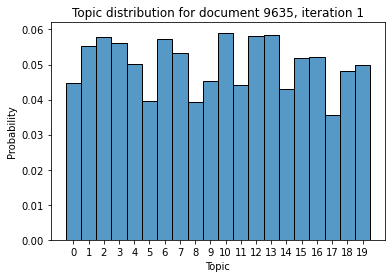

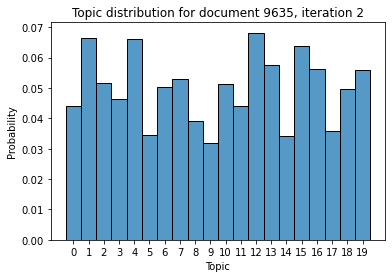

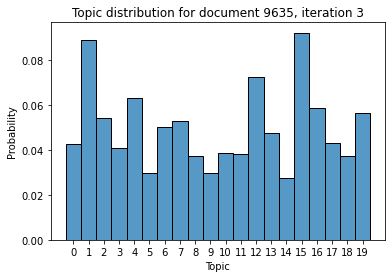

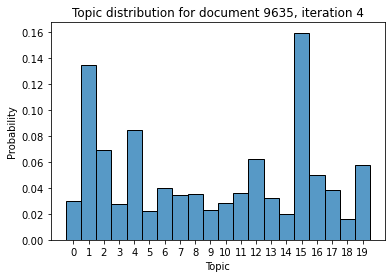

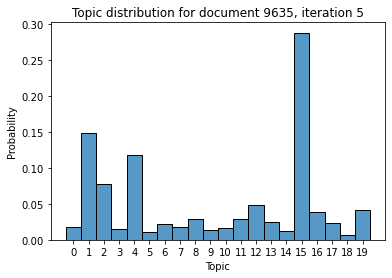

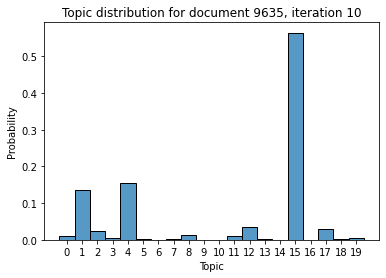

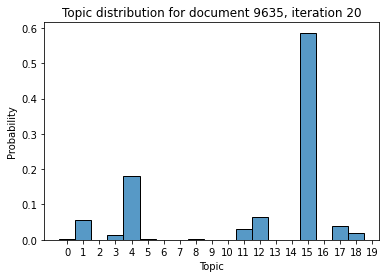

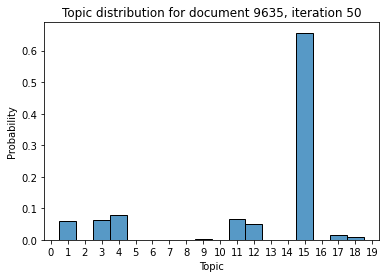

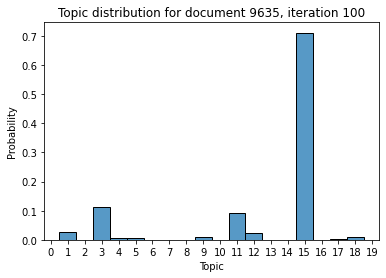

In [16]:
for it in [0, 1, 2, 3, 4, 5, 10, 20, 50, 100]:
    model.load(os.path.join(result_dir, f"model_{it}.pickle"))
    document = model.z_nd[max_len_document]

    ax = sns.histplot(document, stat="probability", discrete=True)
    ax.set_title(f"Topic distribution for document {max_len_document}, iteration {it}")
    ax.set_xlabel("Topic")
    ax.set_xticks(range(topics))
    ax.set_xticklabels(range(topics))
    plt.show()

Based on the document excerpt, the longest article is most likely about sports. 

Now let's look at the probability distribution over topics for this document after each iteration. We can see that the distribution is nearly uniform at the start. This makes sense because we have initialized the topics uniformly for each word. After 5 iterations we can see that the majority of the distribution mass shifts towards topic 15. Throughout the rest of the iterations the distribution becomes more and more concentrated on topic 15. At the 100th iteration the probability of the topic 15 is 0.7. Next most probable topics are 3 and 11. 

We can hypothesize that the LDA model has converged to a solution where topic 15 is about sports. We will look at the top 20 words for this topic later in the notebook.

## Task 3
Compute the word entropy for each of the topics as a function of the
number of Gibbs iterations. Plot them all in one figure. 

In [17]:
iterations = 100
H_ki = [[] for i in range(topics)]

for it in range(iterations):
    model.load(os.path.join(result_dir, f"model_{it}.pickle"))
    for k in range(topics):
        H_ki[k].append(model.entropy_topic(k))

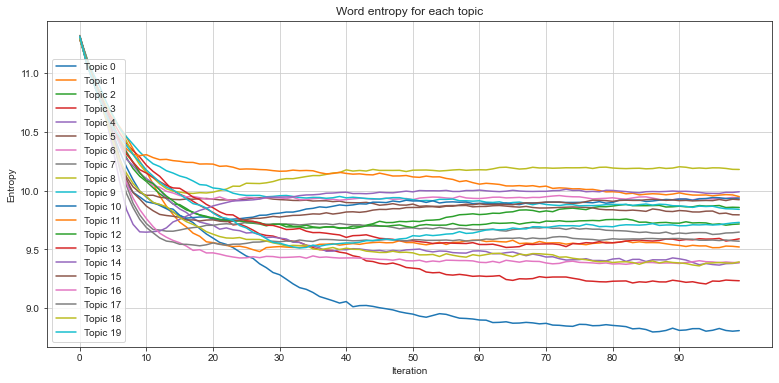

In [18]:
plt.figure(figsize=(13,6))
sns.set_style("ticks",{'axes.grid' : True})
for k, H_k in enumerate(H_ki):
    ax = sns.lineplot(x=np.arange(iterations), y=H_k, label=f"Topic {k}")
    ax.set_title(f"Word entropy for each topic")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Entropy")
    xticks = range(0, iterations, 10)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    #plt.show()

As we can see from the plot, the word entropy decreases with the number of iterations. This is expected because the model is getting better at estimating the topic distribution for each word. The largest decrease in the word entropy is in the first 10 iterations. After that the decrease is much smaller as the model converges to a solution.

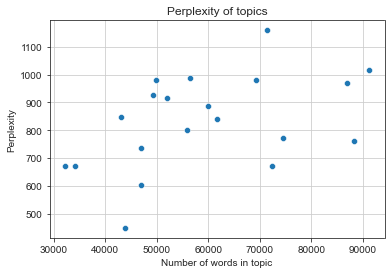

In [31]:
# NOTE: This unused code was inteded to compare the perplexity of a topic and the number of words in the topic. 
# I wanted to look into why some of the topics have higher perplexity than others. The number of words in the topic 
# correlates with perplexity and thus could be a reason but it surely not the only reason.


H_last = [H_k[-1] for H_k in H_ki]
total_word_counts = np.sum(model.c_w, axis=0)
# compute the perplexities from the entropy and zip it with the number of words per topic
perplexities = [(2**H_k, c_w) for H_k, c_w in zip(H_last, total_word_counts)]
# plot the perplexities against the number of words per topic
ax = sns.scatterplot(x=[c_w for _, c_w in perplexities], y=[p for p, _ in perplexities])
ax.set_title(f"Perplexity of topics")
ax.set_xlabel("Number of words in topic")
ax.set_ylabel("Perplexity")
plt.show()


## Task 4
Show histograms of the most frequent 20 words of three chosen topics after 100 Gibbs iterations. What are the chosen topics about?

Top 20 words for topic 15:


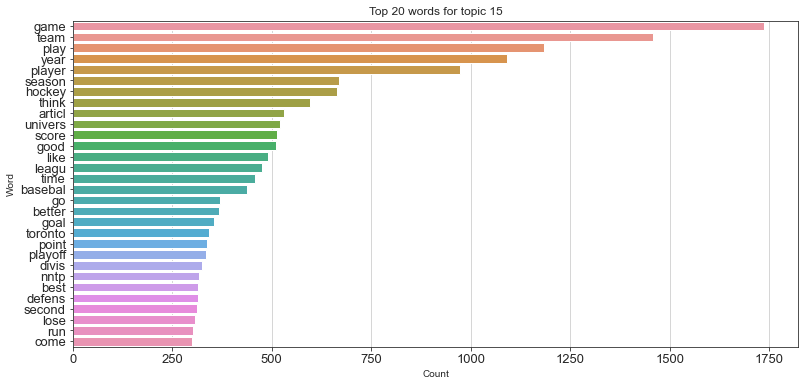

Top 20 words for topic 3:


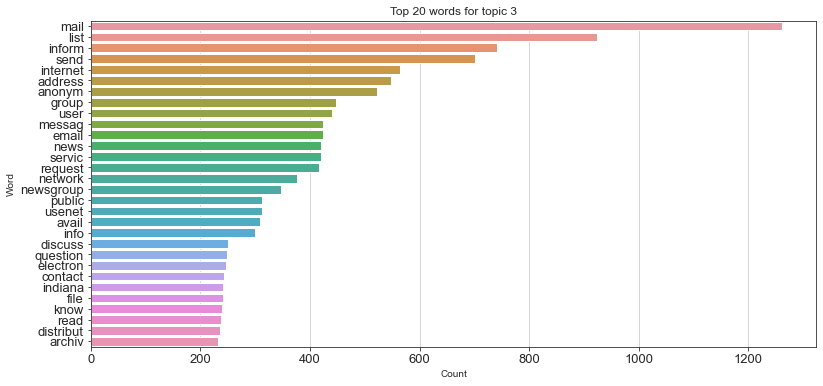

Top 20 words for topic 11:


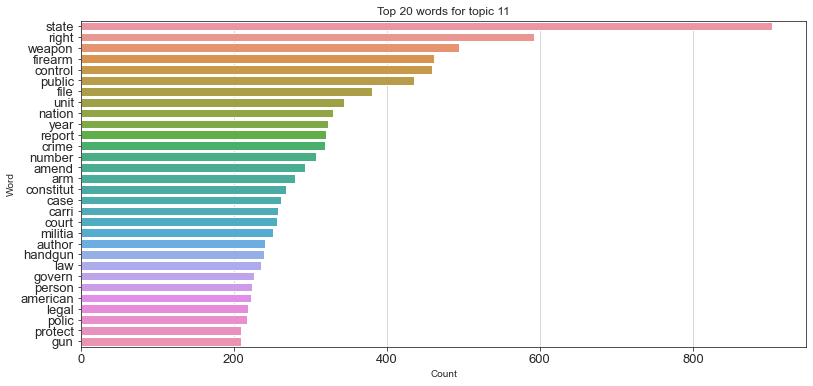

In [19]:
model.load(os.path.join(result_dir, f"model_100.pickle"))
for k in [15, 3, 11]:
    print(f"Top 20 words for topic {k}:")
    top_words_with_counts = model.top_words(k, topn=30)
    # print(top_words_with_counts)
    # plot barplot of top 20 words using seaborn
    # set the figure size
    plt.figure(figsize=(13,6))
    ax = sns.barplot(x=[c for _, c in top_words_with_counts], y=[w for w, _ in top_words_with_counts])
    # set larger font size
    ax.tick_params(labelsize=13)
    ax.set_title(f"Top 20 words for topic {k}")
    ax.set_xlabel("Count")
    ax.set_ylabel("Word")
    plt.show()


Here we look at the top 20 words for topics 15, 3 and 11 which we found to be the most likely topics for the longest article in the dataset.

The most probable words for topic 15 are: game, team, play, year, player, ... This supports our hypothesis that topic 15 is about sports.

The topic 3 contains words like: mail, list, inform, send, ... messag, email, news. The topic is a little more difficult to interpret but it appears to be about the internet and communication.

The topic 11 is much clearer. The most probable words are state, right, weapon, firearm, control, public, ... This topic is about gun control, crime and the law.

To get more insight into the topic 3 which was harder to interpret, we can look at some of the articles from the dataset which are most likely to be about this topic.

In [20]:
c_d = np.array(model.c_d)
article_probabilities = c_d / np.sum(c_d, axis=1)[:, np.newaxis]
article_probabilities = article_probabilities[:, 3]

# find 10 articles with highest probability for topic 3
top_articles = np.argsort(article_probabilities)[::-1][:3]
for i, article in enumerate(top_articles):
    print(f"Article {i}:")
    print(newsgroups_train.data[article])
    print("-"*80)
    

Article 0:
From: mitchell@nodecg.ncc.telecomwa.oz.au (Clive Mitchell)
Subject: Dataproducts LZR1260 not printing correctly
Organization: Regional Network Systems Group, Perth
Lines: 9

Just an apology in advance for posting a binary to this newsgroup.
I've had several attempts to mail it to the original poster but 
it's not getting through intact.

-- 
    _--_|\    Clive Mitchell               ph: +61 9 4916384
   /      \   Regional Network Systems     mitchell@telecomwa.oz.au
>> *_.--._/   Perth , Western Australia
         v

--------------------------------------------------------------------------------
Article 1:
From: dewinter@prl.philips.nl (Rob de Winter)
Subject: WANTED: Symantec address
Originator: dewinter@prl.philips.nl
Organization: Philips Research Laboratories, Eindhoven, The Netherlands
Lines: 5

-- 
*** Nothing beats skiing, if you want to have real fun during holidays. ***
***       Rob de Winter  Philips Research, IST/IT, Building WL-1        ***
***       P.O. Box

Looking at the top 3 articles from the topic 3 we can see that this topic might reflect more the form rather than the content of the articles. The articles seem to be actually emails. If we then look at the longest article we were inspecting earlier, we can see that it is also an email. This might explain why the topic 3 is the second most probable topic for this article.

In [21]:
# NOTE: Unused code for inspecting the lowest and highest perplexity topics

H_last = [H_k[-1] for H_k in H_ki]

model.load(os.path.join(result_dir, f"model_100.pickle"))
print("Words for lowest and highest perplexity")
H_sorted = np.argsort(H_last)
for k in [H_sorted[0], H_sorted[-1]]:
    print(f"Top 20 words for topic {k}, PP={2**model.entropy_topic(k)}:")
    print(model.top_words(k, topn=20))

Words for lowest and highest perplexity
Top 20 words for topic 0, PP=450.20315514108336:
[('host', 1546), ('nntp', 1497), ('univers', 1152), ('articl', 1077), ('know', 697), ('access', 635), ('thank', 634), ('distribut', 549), ('repli', 535), ('world', 484), ('like', 393), ('michael', 382), ('utexa', 376), ('look', 367), ('think', 343), ('engin', 335), ('need', 330), ('scienc', 327), ('mail', 313), ('help', 298)]
Top 20 words for topic 8, PP=1160.2723223966213:
[('articl', 941), ('bike', 740), ('like', 724), ('drive', 527), ('good', 486), ('look', 455), ('think', 452), ('car', 439), ('host', 436), ('time', 426), ('go', 417), ('engin', 395), ('know', 394), ('nntp', 382), ('speed', 346), ('motorcycl', 327), ('road', 322), ('right', 317), ('thing', 315), ('ride', 296)]


## Task 5
Preprocess the test data in the same way as the training data. For filtration, use the dictionary from the training data. Compute the per-word perplexity of the test data for the state after 50 Gibbs iterations. Compare it to a simple bayesian model not using any hidden variables and using only one distribution over words β for all documents with symmetric Dirichlet prior with and concentration parameter γ = 0.1.

In [81]:
model.load(os.path.join(result_dir, f"model_100.pickle"))

test_data = docs_test
z_nd, c_d = model.assign_topics(test_data, 50)
H = model.entropy_data(test_data, z_nd, c_d)
print(f"Entropy of test data: {H}")
print(f"Perplexity of test data: {2**H}")

Entropy of test data: 10.503754409458473
Perplexity of test data: 1451.9282131892421


In [22]:
H = model.entropy_data(docs, model.z_nd, model.c_d)
print(f"Entropy of training data: {H}")
print(f"Perplexity of training data: {2**H}")

Entropy of training data: 10.298928955267035
Perplexity of training data: 1259.7562994835828


In [23]:
# Here we compute entropy and perplexity for the simple bayesian model
gamma = 0.1
c_w = np.zeros(len(dictionary))
for d in docs:
    for w in d:
        c_w[w] += 1
H = 0

n_words = sum(c_w)
for d in docs:
    for w in d:
        p_w = (gamma + c_w[w]) / (gamma * len(dictionary) + n_words)
        H -= np.log2(p_w)
H = H / n_words
2**H
print(f"Entropy of test data with the bayesian model: {H}")
print(f"Perplexity of test data with the bayesian model: {2**H}")

Entropy of test data with the bayesian model: 11.349631951428972
Perplexity of test data with the bayesian model: 2609.634331234366


As we can see, the perplexity of our LDA model is lower than the perplexity of the simple bayesian model. This means that the LDA model is better at modelling the test data (lower perplexity means that the model is less "surprised" by the test data). Interestingly this is the case even though the bayesian model has an advantage of being constructed directly from the test data - as opposed to the LDA model which is trained on the training data and has not seen the test data before.
We also compare the perplexity on the training data for the LDA model. Compared to the test data perplexity, the training data perplexity is lower. This is expected because the model was trained on the training data and thus should be better at generating it.

## Task 6
Try to change the number of topics K, the hyperparameters α and γ and the number of Gibbs iterations. How the performance changes? Which model has the lowest perplexity?

By observing the topic entropies from the task 3 we can see that the model starts to converge to a solution after about 50 iterations. For the hyperparameter sweep we will thus use 50 iterations to save time. To get a better estimate of the perplexity we will use 5 different random initializations of the model and average the perplexity over them.

In [25]:
import time
# plot training perplexity over iterations
iterations = 100
for it in range(0, iterations, 5):
    model.load(os.path.join(result_dir, f"model_{it}.pickle"))
    start_time = time.time()
    H = model.entropy_data(docs, model.z_nd, model.c_d)
    print(f"Perplexity of training data for iteration {it}: {2**H}")
    print(f"Time={round(time.time() - start_time, 2)}")

Perplexity of training data for iteration 0: 2606.451809688226
Time=24.14
Perplexity of training data for iteration 5: 2149.3542616609757
Time=14.17
Perplexity of training data for iteration 10: 1626.2279459516108
Time=12.6
Perplexity of training data for iteration 15: 1457.477389835781
Time=15.18
Perplexity of training data for iteration 20: 1383.4952701732939
Time=13.42
Perplexity of training data for iteration 25: 1344.6957912968132
Time=12.57
Perplexity of training data for iteration 30: 1321.620930025454
Time=14.88


KeyboardInterrupt: 

In [ ]:
@njit
def entropy_data(docs: np.ndarray, z_nd: np.ndarray, c_d: np.ndarray) -> float:
    H = 0
    Mgamma = self.wrd_cnt * self.gamma
    N_test = sum(len(doc) for doc in docs)
    word_probs = np.zeros(N_test)
    word_idx = 0
    for d in range(len(docs)):
        for w in docs[d]:
            N_d = len(docs[d])
            KalphaN_d = self.topics * self.alpha + N_d
            for k in range(self.topics):
                word_probs[word_idx] += (
                    (self.alpha + c_d[d][k])
                    / KalphaN_d
                    * (self.gamma + self.c_w[w][k])
                    / (Mgamma + self.c[k])
                )
            word_idx += 1

    H = -np.sum(np.log2(word_probs)) / N_test

    return H


In [26]:
import time
# plot training perplexity over iterations
iterations = 100
for it in range(0, iterations, 5):
    model.load(os.path.join(result_dir, f"model_{it}.pickle"))
    start_time = time.time()
    H = model.entropy_data(docs, model.z_nd, model.c_d)
    print(f"Perplexity of training data for iteration {it}: {2**H}")
    print(f"Time={round(time.time() - start_time, 2)}")

Perplexity of training data for iteration 0: 2606.4518096884826
Time=23.3
Perplexity of training data for iteration 5: 2149.3542616598324
Time=19.93
Perplexity of training data for iteration 10: 1626.2279459519073
Time=20.33
Perplexity of training data for iteration 15: 1457.477389835519
Time=20.17
Perplexity of training data for iteration 20: 1383.4952701728032
Time=19.82
Perplexity of training data for iteration 25: 1344.6957912967405
Time=20.33
Perplexity of training data for iteration 30: 1321.6209300252995
Time=19.52
Perplexity of training data for iteration 35: 1306.6563954919877
Time=21.0


KeyboardInterrupt: 

In [ ]:
import random
import time

def train(iterations, topics, alpha, gamma, seed):
    # set seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)

    # latent dirichlet allocation topic model
    model = LDATopicModel(docs, dictionary, topics, alpha, gamma)

    # create folder for intermediate results
    result_dir = f"hyperparameter_search/ldamodel_topics{topics}_alpha{alpha}_gamma{gamma}_iterations{iterations}"
    os.makedirs(result_dir, exist_ok=True)
    model.save(os.path.join(result_dir, f"model_0.pickle"))

    perplexities = []

    # run iterations
    for it in range(iterations):
        print("Iteration", it + 1, end="")
        start_time = time.time()
        model.step()

        if it % 10 == 0:
            H = model.entropy_data(docs, model.z_nd, model.c_d)
            PP = 2**H
            perplexities.append((it, PP))
            print(f"PP={PP}", end="")

        print(f"Time={round(time.time() - start_time, 2)}")
        model.save(os.path.join(result_dir, f"model_{it+1}.pickle"))
    return perplexities, model

results = []
for alpha in [0.01, 0.1, 1, 10]:
    for gamma in [0.01, 0.1, 1, 10]:
        for seed in [0, 1, 2]:
            perplexities, model = train(iterations=50, topics=20, alpha=0.1, gamma=0.1, seed=seed)
            results.append({
                "perplexities": perplexities,
                "model": model,
                "seed": seed,

            })